# Translation from the Same Side

This notebook demonstrates the translation of a character from and to the same domain (e.g., front to front).

In [9]:
import logging_utils

from ModelProxy import Pix2PixModelProxy, StarGANModelProxy, CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    'Pix2Pix': lambda: Pix2PixModelProxy('models/pix2pix'),
    # 'stargan': lambda: StarGANModelProxy('models/selection/stargan-network-and-sampler/paired/target-multi/network-disc'), # went to sbgames'24 originally
    'StarGAN': lambda: StarGANModelProxy(
        'models/stargan'),
    'CollaGAN-1': lambda: CollaGANModelProxy(
        'models/collagan'),
}

In [10]:
from dataset_utils import DatasetLoader

dataset_loader = DatasetLoader("all", "test", limit=None)

## Generates a batch of characters a few steps in the future

To verify if a model can "regenerate" a character by translating an image to its same domain while improving its quality, we generate a batch of images and then feed the generated sprites back to the generator a few times (e.g., 1, 2, 5, 10) to see how the quality of the image improves.

In [15]:
import tensorflow as tf
from dataset_utils import load_image

def generate_batch_with_each_model(input_images, domain=2, steps=None):
    """
    Generates a batch of images for each model in the model loaders dictionary
    :param model_loader: 
    :param model_name: 
    :param input_images: a list of image tensors in the shape of [64, 64, 4] with values between [-1, 1] 
    :param domain: an integer indicating the source and target domain
    :param steps: a list of integers indicating the number of generation iterations to generate the image with
    :return: a list of parameters to be used for the image display function
    """
    if steps is None:
        steps = [1, 2, 5, 10]
    steps.sort()
    max_steps = steps[-1]
    
    domains_before = domain
    domains_after = 4 - domain - 1
    number_of_models = len(model_loaders)
    number_of_images = len(input_images)

    # input_images [(64, 64, 4) x len] -> (b, 64, 64, 4)
    input_images = tf.stack(input_images, axis=0)
    batchify_images = lambda x: tf.pad(x[tf.newaxis, ...], [
        [domains_before, domains_after], 
        [0, 0], [0, 0], [0, 0], [0, 0]], constant_values=0)
    # batchify: (b, 64, 64, 4) -> (4, b, 64, 64, 4) 
    
    genned_images = []
    for model_name, model_loader in model_loaders.items():
        generator = model_loader()
    
        source_images = input_images
        fake_images_with_model = []
        for n in range(1, max_steps+1):
            batch = batchify_images(source_images)
            fake_images = generator.generate(domain, domain, batch)
            source_images = fake_images
            
            if n in steps:
                fake_images_with_model += [fake_images]
                
        fake_images_with_model = tf.stack(fake_images_with_model)
        # fake_images_with_model: (len(steps), b, 64, 64, 4)
        
        genned_images += [fake_images_with_model]
        del generator
    
    # genned_images: [len(steps), b, 64, 64, 4] * len(models)
    genned_images = tf.stack(genned_images, 1)
    # genned_images: (len(steps), len(models), b, 64, 64, 4)
    genned_images = tf.transpose(genned_images, [0, 2, 1, 3, 4, 5])
    # genned_images: (len(steps), b, len(models), 64, 64, 4)
    genned_images = tf.reshape(genned_images, [len(steps), number_of_models * number_of_images, 64, 64, 4])
    # genned_images: (len(steps), b * len(models), 64, 64, 4)
    genned_images = tf.unstack(genned_images)
    # genned_images: [(len(models) * b, 64, 64, 4) x len(steps)]
    
    input_images = tf.repeat(input_images, number_of_models, axis=0)
    return input_images, 0., genned_images, tf.repeat([domain], len(input_images)), [f"After {n} iteration{'s' if n>1 else ''}" for n in steps], list(model_loaders.keys())*len(input_images)
    
images = [load_image(f"adhoc-images/{file_name}") for file_name in [
    # "front-blob.png",
    # "front-segmented.png", 
    # "front-blurry.png",
    # "front-damaged.png",
    "front-with-hole.png"
    ]]

imgs_params = generate_batch_with_each_model(images, domain=2, steps=[1, 3, 6, 10, 100])

2024-06-20 17:41:51 INFO     Start >> Loading Pix2Pix model front-to-front
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
2024-06-20 17:41:56 INFO     End   >> Loading Pix2Pix model front-to-front
D:\Projetos 2\dissertation-notebooks\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than 

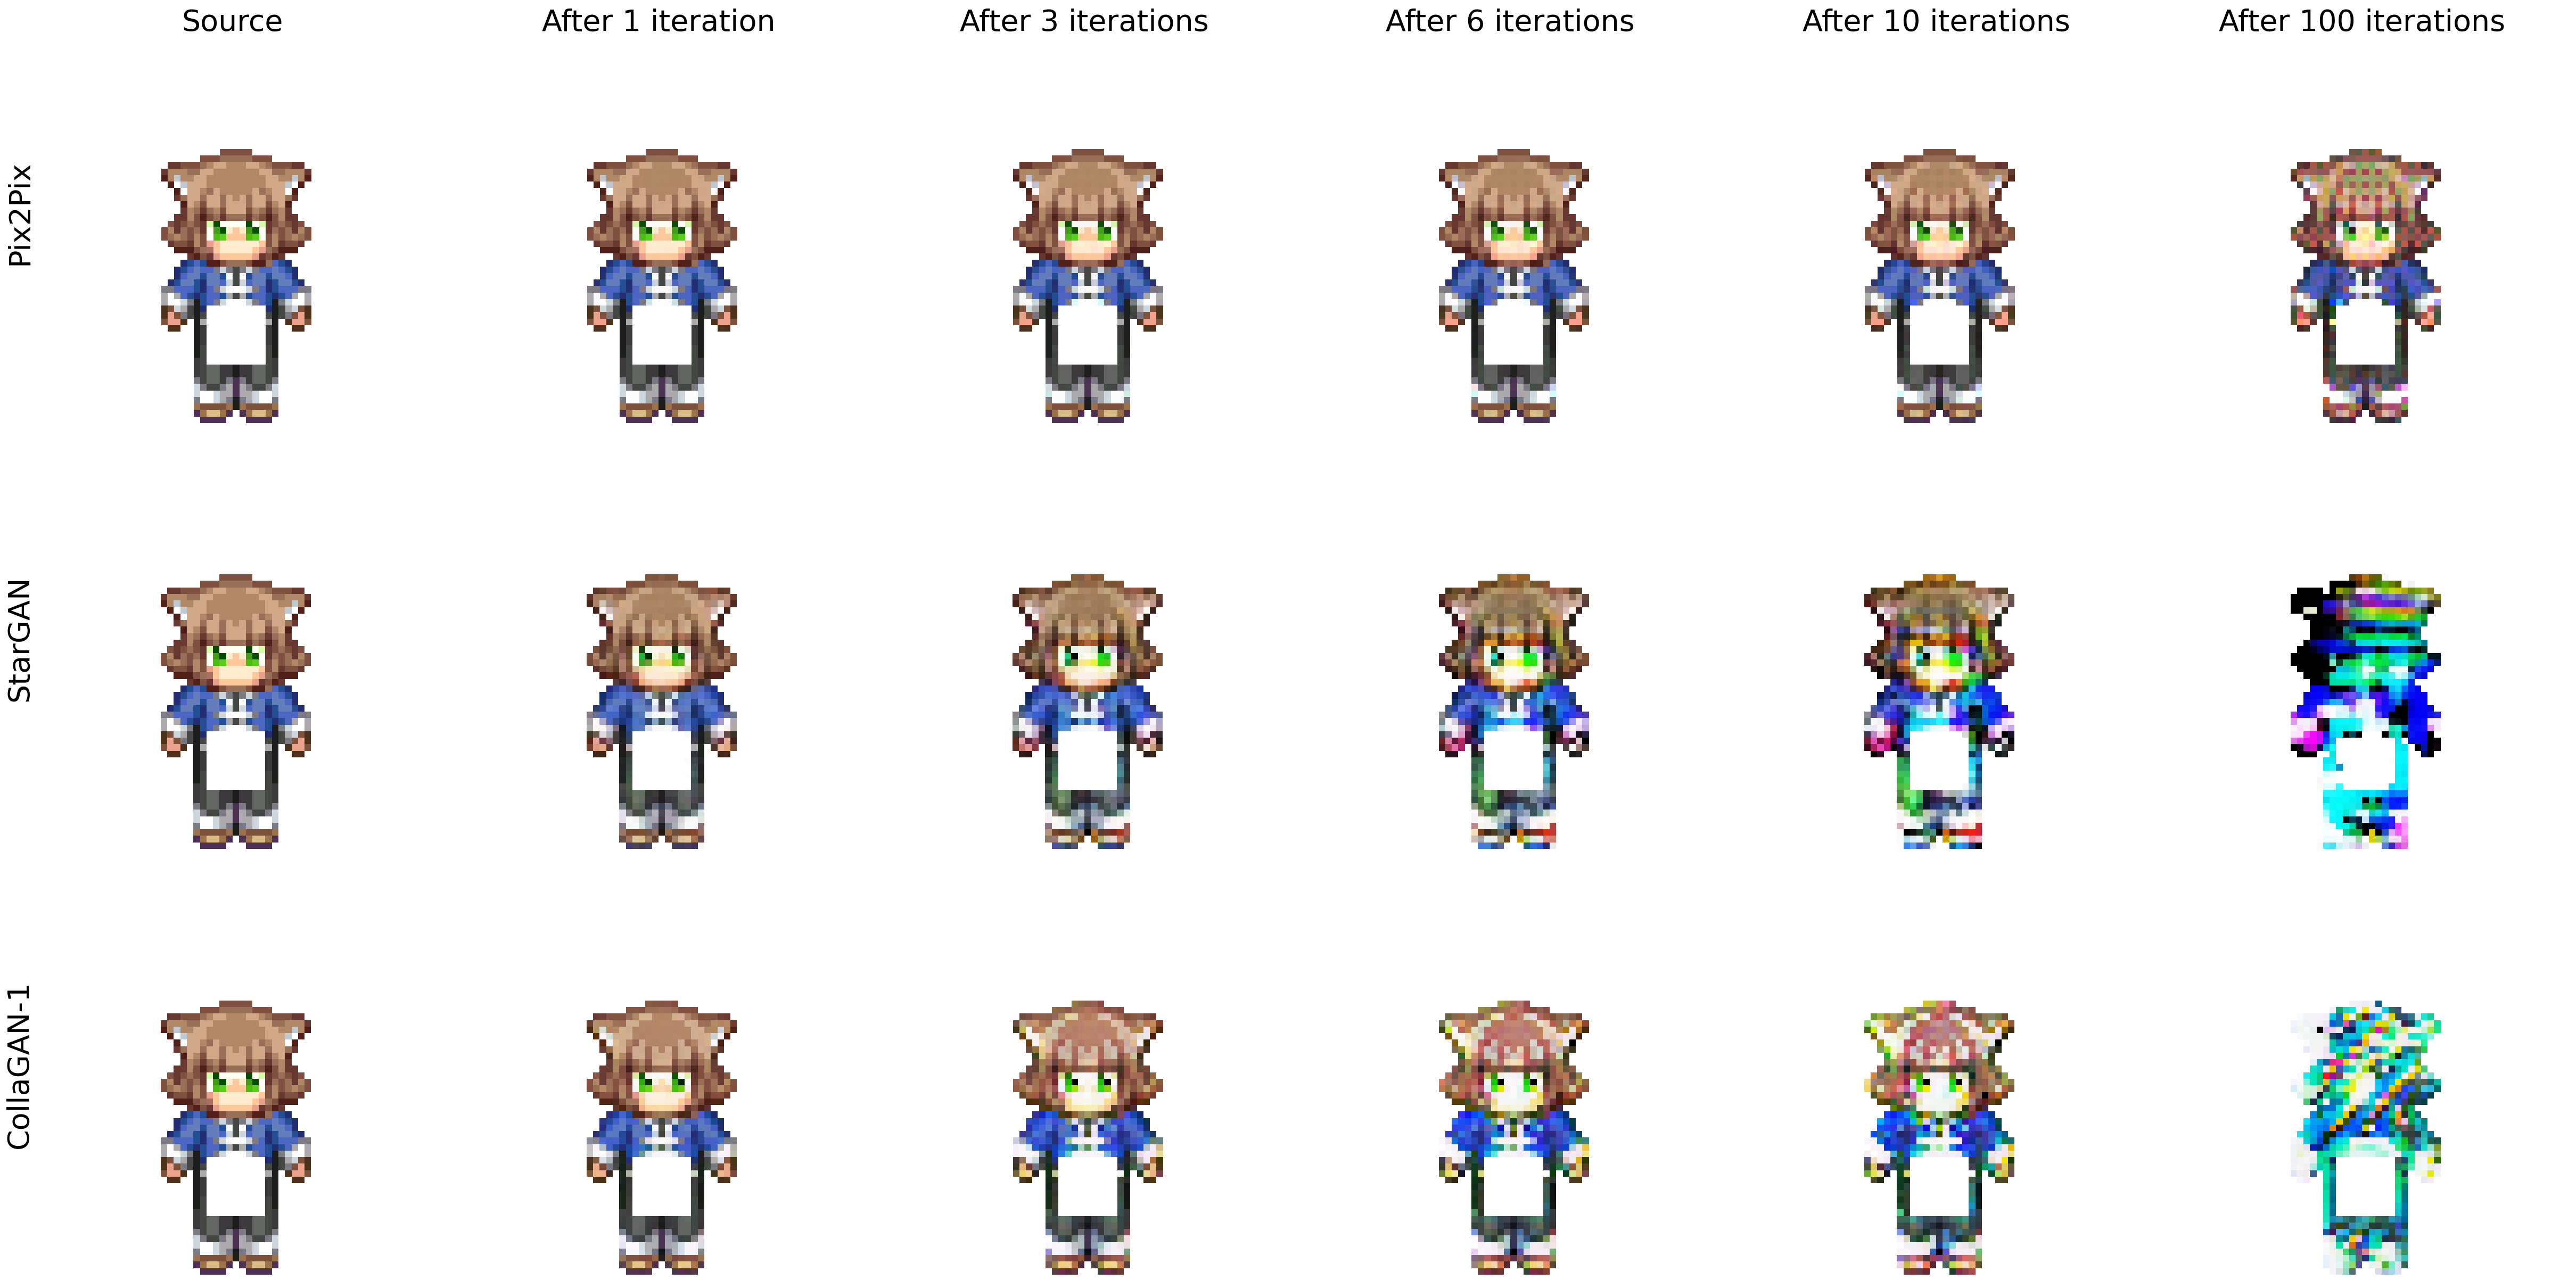

In [16]:
from matplotlib import pyplot as plt
from image_utils import show_comparison

f = show_comparison(*imgs_params, suppress_target=True)
f.patch.set_alpha(0.0)
plt.savefig("output/same_side_translation.png", format="png", transparent=True)    

We can observe that, generally, the models can change the input image to a different version, either adding noise or sharpening them, but adding different colors or completely disfiguring the character after many iterations.